In [1]:
import keras
import numpy as np
import tensorflow as tf
from keras.models import Sequential,load_model
import keras.backend as K
from commai_spd_chl_keras_datagen import commai_speed_chl_gen
from keras.layers import Dense, Activation,ConvLSTM2D,Lambda,GRU,BatchNormalization,Activation,Flatten,TimeDistributed,Conv2D,MaxPooling3D,MaxPooling2D,LSTM,Reshape,Dropout

Using TensorFlow backend.


In [ ]:
1*1

In [6]:
#run only once
#com_gen=commai_speed_chl_gen()
#com_gen.build_video_folder()

  0%|          | 28/20400 [00:00<01:13, 278.09it/s]

(480, 640, 3)
(32, 3, 480, 640)
(32, 3, 1)
building video Database


100%|██████████| 20400/20400 [01:35<00:00, 213.79it/s]


In [2]:
tf.config.list_physical_devices ()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
keras.backend.image_data_format()

In [2]:
seq = Sequential()

seq.add(Lambda(lambda x:tf.divide(x,255),input_shape=(3,480,640,1))) # Normalize the images between 0-1

seq.add(TimeDistributed(Conv2D(filters=16, kernel_size=(4,4), #basically "resize the images" since ConvLSTM2Ds are expensive as shit
                   padding='same')))
seq.add(TimeDistributed(MaxPooling2D(pool_size=(4,4)))) 
seq.add(Activation("relu"))

seq.add(ConvLSTM2D(filters=16, kernel_size=(8,8),
                   padding='same',return_sequences=True))
seq.add(TimeDistributed(MaxPooling2D(pool_size=(8,8)))) #pool every single dim of shared features 
seq.add(Dropout(0.3))
seq.add(BatchNormalization()) 
seq.add(Activation("relu"))


seq.add(ConvLSTM2D(filters=32,return_sequences=True, kernel_size=(8,8),
                   padding='same'))
seq.add(TimeDistributed(MaxPooling2D(pool_size=(8,8))))
seq.add(BatchNormalization())
seq.add(Activation("relu"))
seq.add(Dropout(0.2))

seq.add(Reshape((3,2*32)))

seq.add(BatchNormalization()) #better approch since data can sometimes "slip" from the normalization statistics
seq.add(GRU(50,activation="relu",return_sequences=True))

seq.add(Dense(100,))
seq.add(Activation("relu"))
seq.add(Dropout(0.1))

seq.add(Dense(1))
seq.add(Activation("relu"))

seq.compile(loss='mse', optimizer='adam')
seq.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 3, 480, 640, 1)    0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 3, 480, 640, 16)   272       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 3, 120, 160, 16)   0         
_________________________________________________________________
activation_1 (Activation)    (None, 3, 120, 160, 16)   0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 3, 120, 160, 16)   131136    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 3, 15, 20, 16)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 15, 20, 16)    

In [3]:
batch_size=32
n_e=60
n_frames_train=16000
n_frames_test=2000
n_frames_valid=2400

train_idx,test_idx,valid_idx=commai_speed_chl_gen(n_frames_valid=n_frames_valid,
                    n_frames_test=n_frames_test,n_frames_train=n_frames_train,batch_size=batch_size).get_indexes()

#load=np.load(open("idxes_32bs_GRU_16k.np","rb"))
#train_idx=load["train_idx"]
#test_idx=load["test_idx"]
#valid_idx=load["valid_idx"]

train_gen=commai_speed_chl_gen(frame_idx=train_idx)
test_gen=commai_speed_chl_gen(frame_idx=test_idx)
valid_gen=commai_speed_chl_gen(frame_idx=valid_idx)

np.savez_compressed(open("idxes_32bs_GRU_16k.np","wb+"),train_idx=train_idx,test_idx=test_idx,valid_idx=valid_idx)



(480, 640, 3)
(32, 3, 480, 640)
(32, 3, 1)
train_samples: 5333 
test_samples:666 
valid_samples: 800
(480, 640, 3)
(32, 3, 480, 640)
(32, 3, 1)
(480, 640, 3)
(32, 3, 480, 640)
(32, 3, 1)
(480, 640, 3)
(32, 3, 480, 640)
(32, 3, 1)


In [4]:
#seq=load_model("new_gen_convLSTM2D-GRU-DENSEOUT-EvenMore_dropout-32bs-BatchNorm-Pool2D-8KS-TDConv2DB4_INPUTS4KS-IMNORM-07-42.39-3.13.hdf5",custom_objects={"tf":tf})
ie=0

filepath="new_gen_convLSTM2D-GRU-16k-DENSEOUT-EvenMore_dropout-32bs-BatchNorm-Pool2D-8KS-TDConv2DB4_INPUTS4KS-IMNORM-{epoch:02d}-{val_loss:.2f}-{loss:.2f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False)

cbs=[checkpoint]
hst=seq.fit_generator(train_gen,  max_queue_size=85,steps_per_epoch=n_frames_train/batch_size, epochs=n_e,workers=10,
        use_multiprocessing=True,validation_data=test_gen,callbacks=cbs,verbose=1,shuffle=True, initial_epoch=ie)

Epoch 1/60
500/500 [==============================] - 820s 2s/step - loss: 49.2278 - val_loss: 11.6995

Epoch 00001: saving model to new_gen_convLSTM2D-GRU-16k-DENSEOUT-EvenMore_dropout-32bs-BatchNorm-Pool2D-8KS-TDConv2DB4_INPUTS4KS-IMNORM-01-11.70-49.23.hdf5
Epoch 2/60
500/500 [==============================] - 816s 2s/step - loss: 18.4793 - val_loss: 3.0415

Epoch 00002: saving model to new_gen_convLSTM2D-GRU-16k-DENSEOUT-EvenMore_dropout-32bs-BatchNorm-Pool2D-8KS-TDConv2DB4_INPUTS4KS-IMNORM-02-3.04-18.48.hdf5
Epoch 3/60
380/500 [=====================>........] - ETA: 3:12 - loss: 11.8532

Process ForkPoolWorker-115:
Process ForkPoolWorker-119:
Process ForkPoolWorker-99:
Process ForkPoolWorker-120:
Process ForkPoolWorker-112:
Process ForkPoolWorker-118:
Process ForkPoolWorker-111:
Process ForkPoolWorker-117:
Traceback (most recent call last):
Process ForkPoolWorker-100:
Process ForkPoolWorker-116:
Process ForkPoolWorker-114:
Traceback (most recent call last):
Process ForkPoolWorker-113:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Trace

KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocess

KeyboardInterrupt: 

In [8]:
#7 Epoches
seq=load_model("new_gen_convLSTM2D-GRU-DENSEOUT-EvenMore_dropout-32bs-BatchNorm-Pool2D-8KS-TDConv2DB4_INPUTS4KS-IMNORM-07-42.39-3.13.hdf5",custom_objects={"tf":tf})
seq.evaluate_generator(valid_gen,n_frames_valid/batch_size, max_queue_size = 10,workers = 2,verbose=2)

3.4827985763549805

In [7]:
#15 Epoches
seq=load_model("new_gen_convLSTM2D-GRU-Shallow-DENSEOUT-EvenMoreMax_dropout-21bs-BatchNorm-Pool2D-8KS-TDConv2DB4_INPUTS4KS-IMNORM-15-21.07-12.33.hdf5",custom_objects={"tf":tf})
seq.evaluate_generator(valid_gen,n_frames_valid/batch_size, max_queue_size = 100,workers = 5,verbose=2)

66.58946990966797

In [17]:
#20 Epoches
seq=load_model("new_gen_convLSTM2D-GRU-Shallow-DENSEOUT-EvenMoreMax_dropout-21bs-BatchNorm-Pool2D-8KS-TDConv2DB4_INPUTS4KS-IMNORM-20-6.18-23.45.hdf5",custom_objects={"tf":tf})
seq.evaluate_generator(valid_gen,n_frames_valid/batch_size, max_queue_size = 10,workers = 2,verbose=2)

18.8693790435791

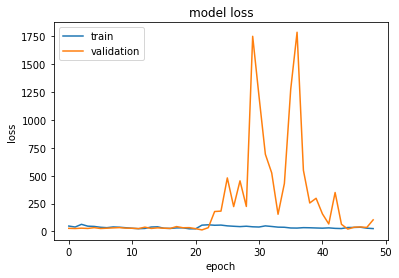

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
#import matplotlib
#matplotlib.use('Agg')

plt.plot(hst.history['loss'])
plt.plot(hst.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('loss.png')